# Logistic Regression on Amazon Fine Food Reviews Dataset

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, make_scorer, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import pickle
import seaborn as sn
from scipy.sparse import csr_matrix
from gensim.models import Word2Vec

In [97]:
df = pd.read_csv("all reviews.csv") # reading the file
df.sort_values("Time", inplace = True)
df.dropna(inplace = True)
df = df[:200000] # taking 2,00,000 reviews
train_X, train_Y = df.Lemmatized[:140000], df.Score[:140000] # 70:30 split
test_X, test_Y = df.Lemmatized[140000:], df.Score[140000:]

# Bag Of Words

In [13]:
bow = CountVectorizer(ngram_range = (1,2))
bow.fit(train_X)
train_X = bow.transform(train_X)
bow_std = StandardScaler(with_mean = False).fit(train_X)
train_X = bow_std.transform(train_X)

## Calculating the optimal parameters using GridSearchCV

I am taking two parameters into consideration for GridSearchCV. One is the C value and the other is class weight. Since the data is imbalanced, I thought of giving weights to the classes. I also added the default weight of {"positive" : 1, "negative" : 1}

In [36]:
parameters ={"C":[.000001,.0001,.01,1,10,1000,100000], 
             "class_weight":[{"positive":1, "negative":1}, {"positive":1, "negative":5}, {"positive":1, "negative":7}, 
             {"positive":1, "negative":10}]} 

The model is not able to classify the negative review and hence in the scoring parameter, instead of calculating f1 score for positive class, I thought of calculating the f1 scores for negative class for which I used make_scorer function from sklearn.metrics class. So this would basically give us the best parameters which would maximize the ability of the model to classify the negative reviews based on f1 score.

In [37]:
# this is a function that would return the f1 score of a negative class
def f1_sc(y_true, pred):
    f1 = f1_score(y_true, pred, pos_label = "negative")
    return f1

In [38]:
# using the make_scorer function which would be given to the GridSearchCV as the scoring parameter
sc = make_scorer(f1_sc)

In [39]:
%%time
lr = LogisticRegression()
grid_cv = GridSearchCV(lr, param_grid = parameters, scoring = sc, cv = 5)
grid_cv.fit(train_X, train_Y)

Wall time: 2h 31min 12s


In [40]:
# this would give us the best parameters
grid_cv.best_estimator_

LogisticRegression(C=1e-06, class_weight={'positive': 1, 'negative': 10},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [41]:
# this would give the mean score of every possible combination of the parameters
# the score in this case is f1 score of negative reviews
grid_cv.grid_scores_

[mean: 0.04021, std: 0.00227, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.58726, std: 0.01653, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.67658, std: 0.01489, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.72581, std: 0.01179, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.26500, std: 0.00923, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.45507, std: 0.01474, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.48925, std: 0.01536, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.52264, std: 0.01462, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.33776, std: 0.00996, params: {'C': 0.01, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.42303, std: 0.01459, params: {'C': 0.01, 'class_weight': {'positive': 1, 'negative': 5

## Testing

In [15]:
test_X = bow.transform(test_X)
test_X = bow_std.transform(test_X)

Testing on Train Dataset


 Accuracy = 0.9968714285714285

Train Error = 0.0031285714285714805

             precision    recall  f1-score   support

   negative       0.98      1.00      0.99     18800
   positive       1.00      1.00      1.00    121200

avg / total       1.00      1.00      1.00    140000



Testing on Test Dataset


 Accuracy = 0.91895

Test Error = 0.08104999999999996

             precision    recall  f1-score   support

   negative       0.76      0.73      0.74      9655
   positive       0.95      0.96      0.95     50345

avg / total       0.92      0.92      0.92     60000



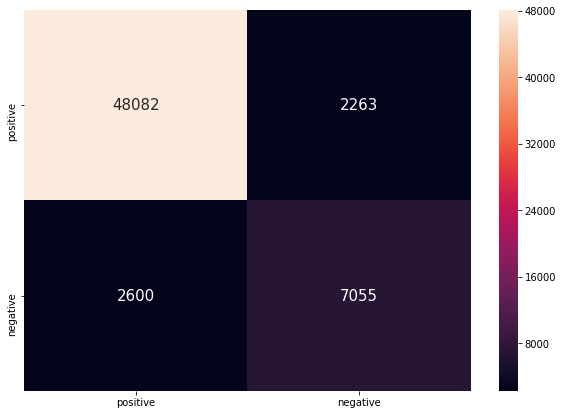

In [44]:
lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X, train_Y)
pred = lr.predict(train_X)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = lr.predict(test_X)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()

## Feature Importance

### Finding out the top 20 positive words

In [45]:
w = lr.coef_
w_sort = w.argsort()
a = w
top_20_positive_words = np.take(bow.get_feature_names(), w_sort[0][:len(a)-21:-1])
print(top_20_positive_words)
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:len(a[0])-21:-1])

['great' 'love' 'best' 'delicious' 'good' 'find' 'favorite' 'perfect'
 'easy' 'highly recommend' 'highly' 'excellent' 'wonderful' 'use' 'nice'
 'make' 'tasty' 'enjoy' 'store']

The corresponding weights are:
[0.01552106 0.01330121 0.01100734 0.00884618 0.00846428 0.0080254
 0.00744244 0.00712744 0.00698388 0.00694784 0.00686189 0.00677544
 0.00674486 0.00593637 0.00589713 0.00578267 0.00565688 0.00561559
 0.0054533  0.00540352]


### Finding out the top 20 negative words

In [46]:
top_20_negative_words = np.take(bow.get_feature_names(), w_sort[0][:21])
print(top_20_negative_words)
a = w
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:21])

['disappoint' 'not buy' 'waste money' 'not worth' 'worst' 'would not'
 'not recommend' 'terrible' 'horrible' 'not' 'awful' 'wont buy' 'waste'
 'money' 'bad' 'throw' 'return' 'not order' 'not purchase' 'not good'
 'stale']

The corresponding weights are:
[-0.01031781 -0.00988552 -0.00956258 -0.00871728 -0.00863605 -0.00841796
 -0.00823087 -0.00791305 -0.00766082 -0.00741443 -0.00739992 -0.00738884
 -0.00730347 -0.00707872 -0.00702657 -0.00695358 -0.00630358 -0.00622522
 -0.00608654 -0.00605732 -0.00582711]


### Checking Multicollinearity using Pertubation technique

In [49]:
train_X_pert, train_Y_pert = df.Lemmatized[:140000], df.Score[:140000]
train_X_pert = bow.transform(train_X_pert)
train_X_pert = bow_std.transform(train_X_pert)

In [50]:
train_X_pert.data = train_X_pert.data + .05

In [53]:
lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X_pert, train_Y_pert)
pred = lr.predict(test_X)
w_pert = lr.coef_

In [54]:
lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X, train_Y)
pred = lr.predict(test_X)
w = lr.coef_

In [55]:
w_diff = abs(w - w_pert)

In [68]:
print(f'average weight of the weight vector is {w.mean()}')
print(f'The average difference in weight vectors is {w_diff.mean()}( ''\033[1m' + f'{(w_diff.mean()/w.mean()) * 100} % )')
print("\033[0m" + f'The maximum difference is {w_diff.max()}')
print(f'The minimum difference is {w_diff.min()}')

average weight of the weight vector is 2.3966257205898114e-05
The average difference in weight vectors is 2.0943835478311093e-07( 0.8738884548546362 % )
The maximum difference is 0.00032166361059520615
The minimum difference is 4.1805485939336307e-13


## L1 Regularization

In [16]:
a = [100000,1000,10,.01,.0001,.000001]

In [17]:
for i in a:
    lr = LogisticRegression(C = i, penalty = "l1")
    lr.fit(train_X, train_Y)
    w = lr.coef_
    pred = lr.predict(test_X)
    report = classification_report(test_Y, pred)
    if i == a[0]:
        print('\033[1m' + f'The total number of words/features are {len(w.ravel())}' + "\033[0m" + '\n')
    print('\033[1m' + f'C = {i}' + "\033[0m")
    print(report)
    print('\033[1m' + f'the number of zero weights are {np.count_nonzero(w == 0)}')
    print("\033[0m" + '\n')

The total number of words/features are 1543667

C = 100000
             precision    recall  f1-score   support

   negative       0.46      0.44      0.45      9655
   positive       0.89      0.90      0.90     50345

avg / total       0.82      0.83      0.83     60000

the number of zero weights are 9290


C = 1000
             precision    recall  f1-score   support

   negative       0.49      0.43      0.46      9655
   positive       0.89      0.92      0.90     50345

avg / total       0.83      0.84      0.83     60000

the number of zero weights are 613173


C = 10
             precision    recall  f1-score   support

   negative       0.87      0.56      0.69      9655
   positive       0.92      0.98      0.95     50345

avg / total       0.91      0.92      0.91     60000

the number of zero weights are 1449135


C = 0.01
             precision    recall  f1-score   support

   negative       0.86      0.59      0.70      9655
   positive       0.93      0.98      0.95   

### Bag of Words without Standardizing
In this case, I did not standardize the data after vectorizing and this actually performed better by a small margin

In [98]:
bow = CountVectorizer(ngram_range = (1,2))
bow.fit(train_X)
train_X = bow.transform(train_X)

In [99]:
%%time
lr = LogisticRegression()
grid_cv = GridSearchCV(lr, param_grid = parameters, scoring = sc, cv = 5)
grid_cv.fit(train_X, train_Y)

Wall time: 5h 1min 53s


In [100]:
grid_cv.best_estimator_

LogisticRegression(C=1, class_weight={'positive': 1, 'negative': 7},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [101]:
grid_cv.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.00000, std: 0.00000, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.00000, std: 0.00000, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.43814, std: 0.00914, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.30525, std: 0.00297, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.23705, std: 0.00003, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.00000, std: 0.00000, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.00000, std: 0.00000, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.04522, std: 0.00209, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.52006, std: 0.00539, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 5}},

In [102]:
test_X = bow.transform(test_X)

Testing on Train Dataset


 Accuracy = 0.9997428571428572

Train Error = 0.0002571428571428447

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     18800
   positive       1.00      1.00      1.00    121200

avg / total       1.00      1.00      1.00    140000



Testing on Test Dataset


 Accuracy = 0.9322333333333334

Test Error = 0.06776666666666664

             precision    recall  f1-score   support

   negative       0.78      0.80      0.79      9655
   positive       0.96      0.96      0.96     50345

avg / total       0.93      0.93      0.93     60000



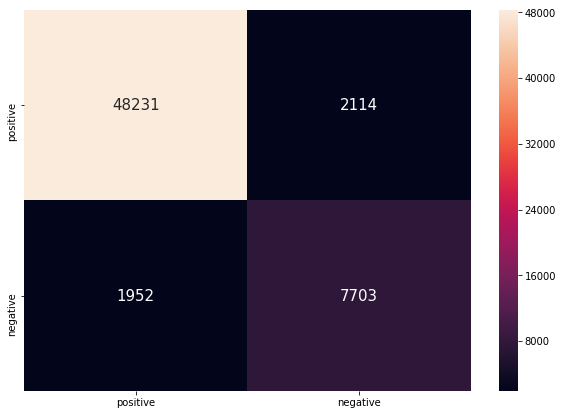

In [103]:
lr = LogisticRegression(C = 1, class_weight = {"positive" : 1, "negative" : 7})
lr.fit(train_X, train_Y)
pred = lr.predict(train_X)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = lr.predict(test_X)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()

In [104]:
w = lr.coef_
w_sort = w.argsort()
a = w
top_20_positive_words = np.take(bow.get_feature_names(), w_sort[0][:len(a)-21:-1])
print(top_20_positive_words)
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:len(a[0])-21:-1])

['not disappoint' 'wont disappoint' 'not bitter' 'delicious'
 'never disappoint' 'not bad' 'not overpower' 'awesome' 'perfect'
 'addictive' 'excellent' 'amaze' 'right amount' 'yummy' 'highly recommend'
 'best' 'wonderful' 'hook' 'great']

The corresponding weights are:
[4.63558487 3.05937435 2.64337561 2.57573047 2.45322328 2.41340853
 2.35903141 2.32444467 2.31422271 2.30922092 2.22873469 2.09342925
 2.07927455 2.07145417 2.06007997 1.99415646 1.95809754 1.9461677
 1.94575977 1.91849372]


In [105]:
top_20_negative_words = np.take(bow.get_feature_names(), w_sort[0][:21])
print(top_20_negative_words)
a = w
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:21])

['not worth' 'worst' 'two star' 'terrible' 'not happy' 'disappoint'
 'horrible' 'wont buy' 'disappointment' 'not recommend' 'awful' 'not good'
 'way sweet' 'disgust' 'dont recommend' 'not great' 'not impress'
 'tasteless' 'not tasty' 'least favorite' 'flavorless']

The corresponding weights are:
[-4.06285671 -3.89511574 -3.07700237 -3.02492837 -2.92935312 -2.89722494
 -2.85606497 -2.77991445 -2.70990298 -2.63642522 -2.61929084 -2.58869011
 -2.54882163 -2.54842891 -2.52886545 -2.48370341 -2.42325042 -2.39446333
 -2.27995477 -2.2665819  -2.25500071]


# TF-IDF

### Vectorizing

In [18]:
train_X, train_Y = df.Lemmatized[:140000], df.Score[:140000]
test_X, test_Y = df.Lemmatized[140000:], df.Score[140000:]

In [21]:
tfidf = TfidfVectorizer(ngram_range = (1,2)).fit(train_X)
train_X_tfidf = tfidf.transform(train_X)
tfidf_std = StandardScaler(with_mean = False).fit(train_X_tfidf)
train_X_tfidf = tfidf_std.transform(train_X_tfidf)
train_Y_tfidf = train_Y

### Finding the optimal parameters

In [22]:
parameters ={"C":[.000001,.0001,.01,1,10,1000,100000], 
             "class_weight":[{"positive":1, "negative":1}, {"positive":1, "negative":5}, {"positive":1, "negative":7}, 
             {"positive":1, "negative":10}]}

In [23]:
def f1_sc(y_true, pred):
    f1 = f1_score(y_true, pred, pos_label = "negative")
    return f1
sc = make_scorer(f1_sc)

In [24]:
%%time
lr = LogisticRegression()
grid_cv_tfidf = GridSearchCV(estimator = lr, param_grid = parameters, scoring = sc, cv = 5)
grid_cv_tfidf.fit(train_X_tfidf, train_Y_tfidf)

Wall time: 1h 34min 49s


In [26]:
grid_cv_tfidf.best_estimator_

LogisticRegression(C=1e-06, class_weight={'positive': 1, 'negative': 10},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [191]:
filename = "Amazon_Logistic_TFIDF.sav"
pickle.dump(grid_cv_tfidf, open(filename, 'wb'))

In [27]:
grid_cv_tfidf.grid_scores_

[mean: 0.02261, std: 0.00189, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.54752, std: 0.01872, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.65397, std: 0.01772, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.71655, std: 0.01252, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.22883, std: 0.00764, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.40291, std: 0.01672, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.43876, std: 0.01840, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.47379, std: 0.01645, params: {'C': 0.0001, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.28991, std: 0.00902, params: {'C': 0.01, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.37802, std: 0.01700, params: {'C': 0.01, 'class_weight': {'positive': 1, 'negative': 5

## Testing

In [28]:
test_X_tfidf = tfidf.transform(test_X)
test_X_tfidf = tfidf_std.transform(test_X_tfidf)
test_Y_tfidf = test_Y

Testing on Train Dataset


 Accuracy = 0.9972

Train Error = 0.0028000000000000247

             precision    recall  f1-score   support

   negative       0.98      1.00      0.99     18800
   positive       1.00      1.00      1.00    121200

avg / total       1.00      1.00      1.00    140000



Testing on Test Dataset


 Accuracy = 0.9147166666666666

Test Error = 0.08528333333333338

             precision    recall  f1-score   support

   negative       0.75      0.70      0.72      9655
   positive       0.94      0.96      0.95     50345

avg / total       0.91      0.91      0.91     60000



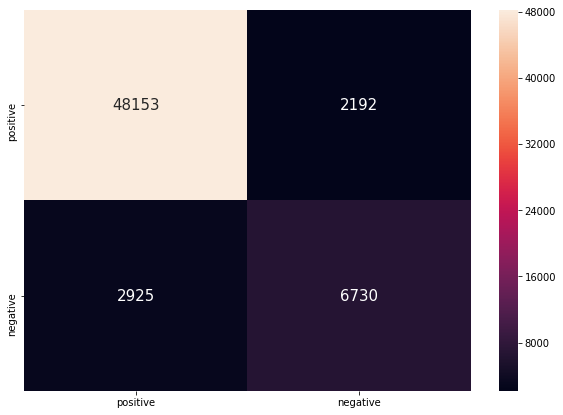

In [31]:
lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X_tfidf, train_Y_tfidf)
pred = lr.predict(train_X_tfidf)
acc = accuracy_score(train_Y_tfidf, pred)
report = classification_report(train_Y_tfidf, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = lr.predict(test_X_tfidf)
acc = accuracy_score(test_Y_tfidf, pred)
report = classification_report(test_Y_tfidf, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()

## Feature Importance

### Top 20 Positive Words

In [32]:
w = lr.coef_
w_sort = w.argsort()
a = w
top_20_positive_words = np.take(tfidf.get_feature_names(), w_sort[0][:len(a)-21:-1])
print(top_20_positive_words)
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:len(a[0])-21:-1])

['great' 'love' 'best' 'good' 'find' 'delicious' 'favorite' 'use' 'make'
 'perfect' 'easy' 'wonderful' 'excellent' 'highly' 'highly recommend'
 'nice' 'enjoy' 'keep' 'well']

The corresponding weights are:
[0.01575414 0.01416944 0.01152625 0.00983735 0.00915642 0.00907233
 0.0078096  0.00758534 0.00746029 0.00743982 0.00732408 0.00689903
 0.00686249 0.0068316  0.00671158 0.00641165 0.00618195 0.00606975
 0.00602041 0.00599846]


### Top 20 Negative Words

In [33]:
top_20_negative_words = np.take(tfidf.get_feature_names(), w_sort[0][:21])
print(top_20_negative_words)
a = w
a.sort()
print("\nThe corresponding weights are:")
print(a[0][:21])

['disappoint' 'not buy' 'not' 'worst' 'would not' 'waste money'
 'not worth' 'terrible' 'not recommend' 'horrible' 'awful' 'waste' 'throw'
 'bad' 'wont buy' 'return' 'money' 'stale' 'not good' 'not order'
 'not purchase']

The corresponding weights are:
[-0.01052208 -0.00995505 -0.00980212 -0.0093065  -0.00913769 -0.00904334
 -0.00868886 -0.00864536 -0.00845357 -0.00833143 -0.0080436  -0.00801933
 -0.00787809 -0.00754677 -0.00720019 -0.00707429 -0.00689195 -0.00673011
 -0.0065581  -0.00608656 -0.00608613]


## Multicollinearity Test using Perturbation Technique

In [37]:
train_X_tfidf_pert, train_Y_pert = df.Lemmatized[:140000], df.Score[:140000]
train_X_tfidf_pert = tfidf.transform(train_X_tfidf_pert)
train_X_tfidf_pert = tfidf_std.transform(train_X_tfidf_pert)

In [38]:
train_X_tfidf_pert.data = train_X_tfidf_pert.data + .05

In [39]:
lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X_tfidf_pert, train_Y_tfidf)
pred = lr.predict(test_X_tfidf)
w_pert = lr.coef_

lr = LogisticRegression(C = 1e-06, class_weight = {"positive" : 1, "negative" : 10})
lr.fit(train_X_tfidf, train_Y_tfidf)
pred = lr.predict(test_X_tfidf)
w = lr.coef_

In [41]:
w_diff = abs(w_pert - w)

In [42]:
print(f'average weight of the weight vector is {w.mean()}')
print(f'The average difference in weight vectors is {w_diff.mean()}( ''\033[1m' + f'{(w_diff.mean()/w.mean()) * 100} % )')
print("\033[0m" + f'The maximum difference is {w_diff.max()}')
print(f'The minimum difference is {w_diff.min()}')

average weight of the weight vector is 2.8152454504186942e-05
The average difference in weight vectors is 2.3859556546334686e-07( 0.8475124804050816 % )
The maximum difference is 0.0002968063215366759
The minimum difference is 9.798742492319462e-13


# Avg Word2Vec

### Vectorizing

In [43]:
reviews = df.Lemmatized[:140000].values
train_data_w2v = []
for i in reviews:
    train_data_w2v.append(i.split())

In [44]:
w2v_model = Word2Vec(train_data_w2v, size = 50)
w2v_words = w2v_model.wv.vocab

In [45]:
%%time
train_reviews_vect = []
for review in train_data_w2v:
    review_vect = np.zeros(50)
    word_count = 0
    for word in review:
        if word in w2v_words:
            word_vect = w2v_model.wv[word]
            review_vect += word_vect
            word_count += 1
    if word_count != 0:
        review_vect /= word_count
    train_reviews_vect.append(review_vect)

    
print(len(train_reviews_vect))
print(len(train_reviews_vect[5]))

140000
50
Wall time: 21.6 s


In [46]:
train_reviews_vect[50]

array([ 0.20140483,  0.33138603,  0.28027764,  0.10718623, -0.09964597,
        0.24153461, -0.32899761,  0.0175052 , -0.31818893,  0.00346149,
       -0.2446005 ,  0.00687168, -0.23513592,  0.39298332,  0.53048769,
        0.16619043, -0.04726319, -0.15966506, -0.12245677,  0.38417833,
       -0.28477625,  0.15706524, -0.19211439, -0.48083255, -0.02792109,
        0.07280422, -0.14476336,  0.50867503, -0.49577767, -0.13196383,
       -0.4463608 , -0.04919616,  0.16179781,  0.01547462, -0.31855976,
       -0.57723449, -0.70349916, -0.191817  ,  0.25034513,  0.40031668,
       -0.22274815,  0.6608193 , -0.26013598,  0.31657744,  0.55243017,
       -0.15358103,  0.4307792 ,  0.21249611,  0.08715484, -0.40469249])

In [47]:
train_Y = df.Score[:140000]

### Finding the optimal parameters

In [48]:
parameters ={"C":[.000001,.00001,.0001,.001,.01,.1,1,10,100,1000,10000,100000], 
             "class_weight":[{"positive":1, "negative":1}, {"positive":1, "negative":2},{"positive":1, "negative":3},
            {"positive":1, "negative":5}, {"positive":1, "negative":7},{"positive":1, "negative":10}]}

In [49]:
def f1_sc(y_true, pred):
    f1 = f1_score(y_true, pred, pos_label = "negative")
    return f1
sc = make_scorer(f1_sc)

In [50]:
%%time
lr = LogisticRegression()
grid_cv_w2v = GridSearchCV(estimator = lr, param_grid = parameters, scoring = sc, cv = 5)
grid_cv_w2v.fit(train_reviews_vect, train_Y)

Wall time: 22min 47s


In [51]:
grid_cv_w2v.best_estimator_

LogisticRegression(C=0.1, class_weight={'positive': 1, 'negative': 2},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [52]:
grid_cv_w2v.grid_scores_

[mean: 0.00074, std: 0.00054, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.00233, std: 0.00128, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.01054, std: 0.00175, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.27938, std: 0.01377, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.37947, std: 0.01149, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.24325, std: 0.00108, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.00148, std: 0.00091, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.01815, std: 0.00303, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.12512, std: 0.00439, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.54587, std: 0.01041, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 5}},

## Testing

In [53]:
reviews = df.Lemmatized[140000:].values
test_data_w2v = []
for i in reviews:
    test_data_w2v.append(i.split())
    
test_reviews_vect = []
for review in test_data_w2v:
    review_vect = np.zeros(50)
    word_count = 0
    for word in review:
        if word in w2v_words:
            word_vect = w2v_model.wv[word]
            review_vect += word_vect
            word_count += 1
    if word_count != 0:
        review_vect /= word_count
    test_reviews_vect.append(review_vect)

    
print(len(test_reviews_vect))
print(len(test_reviews_vect[5]))

60000
50


In [54]:
test_Y = df.Score[140000:]

Testing on Train Dataset


 Accuracy = 0.8996142857142857

Train Error = 0.1003857142857143

             precision    recall  f1-score   support

   negative       0.62      0.64      0.63     18800
   positive       0.94      0.94      0.94    121200

avg / total       0.90      0.90      0.90    140000



Testing on Test Dataset


 Accuracy = 0.8864

Test Error = 0.11360000000000003

             precision    recall  f1-score   support

   negative       0.65      0.65      0.65      9655
   positive       0.93      0.93      0.93     50345

avg / total       0.89      0.89      0.89     60000



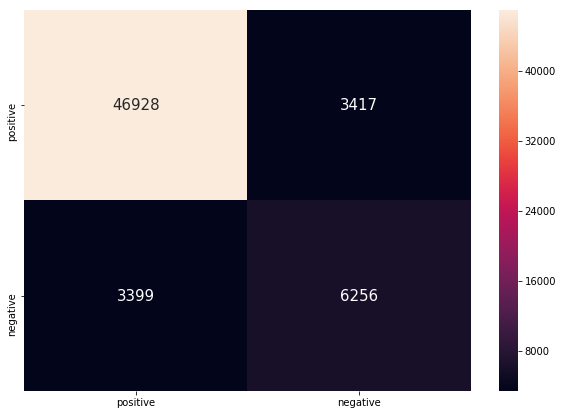

In [55]:
lr = LogisticRegression(C = .1, class_weight = {"positive" : 1, "negative" : 2})
lr.fit(train_reviews_vect, train_Y)
pred = lr.predict(train_reviews_vect)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = lr.predict(test_reviews_vect)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()

# TF-IDF Word2Vec

### Vectorizing

In [79]:
df = pd.read_csv("all reviews.csv")
df.sort_values("Time", inplace = True)
df.dropna(inplace = True)
df = df[:200000]
train_X, train_Y = df.Lemmatized[:140000], df.Score[:140000]
test_X, test_Y = df.Lemmatized[140000:], df.Score[140000:]

In [88]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [89]:
list_of_sent=[]
for sent in train_X.values:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = w2v_model.wv.vocab

In [90]:
tfidf_feat = model.get_feature_names()

train_tfidf_sent_vectors = []
row=0
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [91]:
len(train_tfidf_sent_vectors)

140000

### Calculating Optimal Parameters

In [69]:
parameters ={"C":[.000001,.00001,.0001,.001,.01,.1,1,10,100,1000,10000,100000], 
             "class_weight":[{"positive":1, "negative":1}, {"positive":1, "negative":2},{"positive":1, "negative":3},
            {"positive":1, "negative":5}, {"positive":1, "negative":7},{"positive":1, "negative":10}]}

def f1_sc(y_true, pred):
    f1 = f1_score(y_true, pred, pos_label = "negative")
    return f1
sc = make_scorer(f1_sc)

In [70]:
train_Y = df[:140000].Score

In [72]:
%%time
lr = LogisticRegression()
grid_cv = GridSearchCV(estimator = lr, param_grid = parameters, scoring = sc, cv = 5)
grid_cv.fit(train_tfidf_sent_vectors, train_Y)

Wall time: 22min 51s


In [73]:
grid_cv.best_estimator_

LogisticRegression(C=0.1, class_weight={'positive': 1, 'negative': 3},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [74]:
grid_cv.grid_scores_

[mean: 0.01279, std: 0.00305, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.02576, std: 0.00472, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.06353, std: 0.00448, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.37353, std: 0.01341, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 5}},
 mean: 0.38557, std: 0.01058, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 7}},
 mean: 0.25136, std: 0.00194, params: {'C': 1e-06, 'class_weight': {'positive': 1, 'negative': 10}},
 mean: 0.01378, std: 0.00301, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 1}},
 mean: 0.06146, std: 0.00599, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 2}},
 mean: 0.20111, std: 0.01223, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 3}},
 mean: 0.50433, std: 0.00697, params: {'C': 1e-05, 'class_weight': {'positive': 1, 'negative': 5}},

## Testing

### Vectorizing

In [92]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [93]:
list_of_sent=[]
for sent in test_X.values:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = w2v_model.wv.vocab

In [94]:
tfidf_feat = model.get_feature_names()

test_tfidf_sent_vectors = []
row=0
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

In [95]:
len(test_tfidf_sent_vectors)

60000

Testing on Train Dataset


 Accuracy = 0.8727928571428571

Train Error = 0.12720714285714285

             precision    recall  f1-score   support

   negative       0.52      0.66      0.58     18800
   positive       0.95      0.91      0.92    121200

avg / total       0.89      0.87      0.88    140000



Testing on Test Dataset


 Accuracy = 0.78565

Test Error = 0.21435000000000004

             precision    recall  f1-score   support

   negative       0.33      0.33      0.33      9655
   positive       0.87      0.87      0.87     50345

avg / total       0.79      0.79      0.79     60000



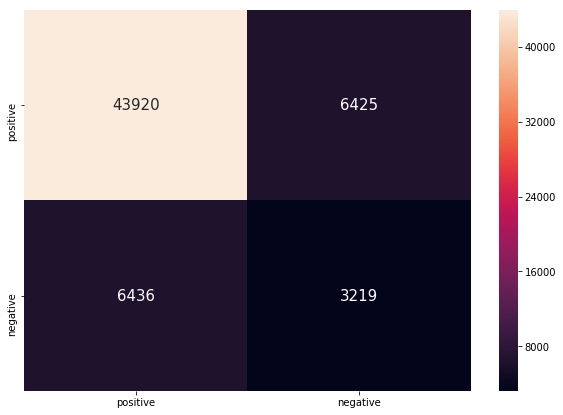

In [96]:
lr = LogisticRegression(C = .1, class_weight = {"positive" : 1, "negative" : 3})
lr.fit(train_tfidf_sent_vectors, train_Y)
pred = lr.predict(train_tfidf_sent_vectors)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = lr.predict(test_tfidf_sent_vectors)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()

# Conclusion

<table align = "left">  <thead style = "font-size : 15px">    <tr style="text-align: right;">        <th style="text-align: center;">Model</th>      <th style="text-align: center;">C</th>      <th style="text-align: center;">Class Weight(Positive:Negative)</th>      <th style="text-align: center;">Train Error</th>      <th style="text-align: center;">Test Error</th>      <th style="text-align: center;">f1-Score of Positive class</th>      <th style="text-align: center;">f1-Score of Negative class</th>    </tr>  </thead>  <tbody style="font-size:15px;">    <tr>     <td style="text-align: center;">BoW without Standardizaion</td>      <td style="text-align: center;">1</td>      <td style="text-align: center;">1:7</td>      <td style="text-align: center;">0.000257</td>      <td style="text-align: center;">0.067766</td>      <td style="text-align: center;">0.96</td>      <td style="text-align: center;">0.79</td>    </tr>    <tr>         <td style="text-align: center;">BoW with Standardizaion</td>      <td style="text-align: center;">0.000001</td>      <td style="text-align: center;">1:10</td>      <td style="text-align: center;">0.003128</td>      <td style="text-align: center;">0.081040</td>      <td style="text-align: center;">0.95</td>      <td style="text-align: center;">0.74</td>    </tr>    <tr>        <td style="text-align: center;">TF-IDF with Standardization</td>      <td style="text-align: center;">0.000001</td>      <td style="text-align: center;">1:10</td>      <td style="text-align: center;">0.002800</td>      <td style="text-align: center;">0.085280</td>      <td style="text-align: center;">0.95</td>      <td style="text-align: center;">0.72</td>    </tr>    <tr>      <td style="text-align: center;">Avg Wor2Vec</td>      <td style="text-align: center;">0.1</td>      <td style="text-align: center;">1:2</td>      <td style="text-align: center;">0.100385</td>      <td style="text-align: center;">0.113600</td>      <td style="text-align: center;">0.93</td>      <td style="text-align: center;">0.65</td>    </tr>    <tr>      <td style="text-align: center;">TF-IDF Word2Vec</td>      <td style="text-align: center;">0.1</td>      <td style="text-align: center;">1:3</td>      <td style="text-align: center;">0.127207</td>      <td style="text-align: center;">0.214350</td>      <td style="text-align: center;">0.87</td>      <td style="text-align: center;">0.33</td>    </tr>  </tbody></table>

<br>
<p style = "font-size: 18px;"> As we can see, <b>Bag of Words </b>performed the best </p>